# Import

In [1]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import pandas as pd
import numpy as np

In [2]:
merged_df = pd.read_csv('protein_expression.csv')
inputed_columns = ['AGID00215',
 'AGID00537',
 'AGID00536',
 'AGID00211',
 'AGID00485',
 'AGID00383',
 'AGID00216',
 'AGID00257',
 'AGID00545',
 'AGID00413',
 'AGID00547',
 'AGID00144']

In [3]:
protein_columns = merged_df.columns.drop(["ajcc_pathologic_stage","vital_status","days_to_death","days_to_last_follow_up","case_submitter_id"])
protein_columns

Index(['AGID00100', 'AGID00111', 'AGID00101', 'AGID00001', 'AGID00002',
       'AGID00003', 'AGID00443', 'AGID00120', 'AGID00004', 'AGID00005',
       ...
       'AGID00349', 'AGID02137', 'AGID00088', 'AGID00089', 'AGID00504',
       'AGID00095', 'AGID02217', 'AGID02210', 'AGID00326', 'AGID00432'],
      dtype='object', length=468)

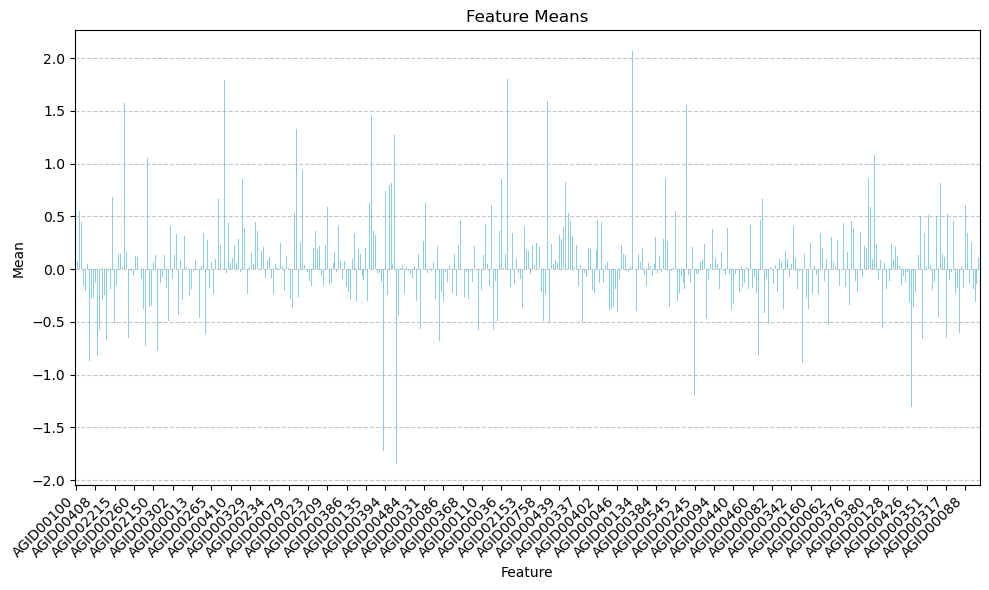

In [4]:
describe_df = merged_df[protein_columns].describe()
row_means = describe_df.loc['mean']

# Plot row means
plt.figure(figsize=(10, 6))
row_means.plot(kind='bar', color='skyblue')
plt.title('Feature Means')
plt.xlabel('Feature')
plt.ylabel('Mean')

plt.xticks(range(0, len(row_means), 10), row_means.index[::10], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.show()

In [5]:
merged_df = merged_df.drop(["ajcc_pathologic_stage","vital_status","days_to_last_follow_up","case_submitter_id"], axis=1)
other = merged_df.columns.drop("days_to_death")

scaler = MinMaxScaler()
merged_df[other] = scaler.fit_transform(merged_df[other])

X_train, X_test, y_train, y_test = train_test_split(merged_df[other], merged_df["days_to_death"],
                                                    train_size=0.75,
                                                    random_state=1)

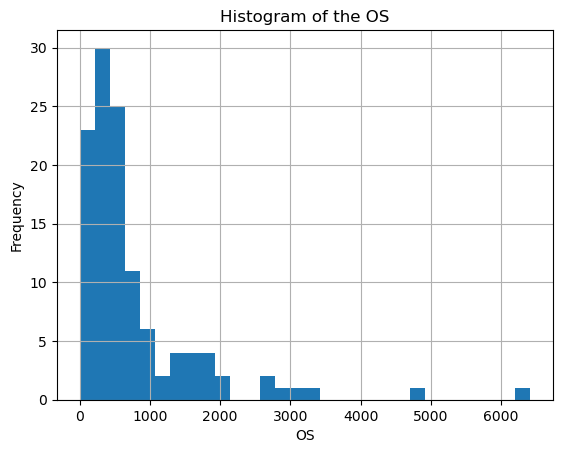

In [6]:
y_train.hist(bins=30) 
plt.xlabel('OS')
plt.ylabel('Frequency')
plt.title('Histogram of the OS')
plt.show()

In [26]:
a = y_test.map(AE.map_years_to_group)

In [33]:
b = [2,3]

# AE

In [43]:
class AE():
    def __init__(self,X_train,X_test,y_train,y_test,bottleneck,type):
        self.X_train = X_train
        self.X_test = X_test        
        self.y_train = y_train
        self.y_test = y_test
        self.bottleneck = bottleneck
        self.history = None
        self.encoder = None
        self.autoencoder = None
        self.type = type
        self.classifer = None

    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))
        encoder = Dense(64, activation='relu')(input_layer)
        encoder = Dense(32, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(32, activation='relu')(bottleneck)
        decoder = Dense(64, activation='relu')(decoder)
        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        self.history = self.autoencoder.fit(self.X_train, self.X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(self.X_test, self.X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()

    def plot(self):
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss '+ self.type)
        plt.legend()
        plt.show()

    def encode(self):
        self.autoencoder.load_weights(f'model/{self.type}_best_model.keras')
        self.encoded_X_train = self.encoder.predict(self.X_train)
        self.encoded_X_test = self.encoder.predict(self.X_test)
    
    def do_PCA(self,n_components):
        if self.bottleneck == 2:
            # pca = PCA(n_components=n_components)
            # reduced_data = pca.fit_transform(self.encoded_X_test)
            x = self.encoded_X_test[:, 0]
            y = self.encoded_X_test[:, 1]
            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(x, y, c=self.y_test_in_bin, cmap='viridis', alpha=0.7)
            plt.title('Encoded Data '+self.type)
            plt.xlabel('Encoded Dim 0')
            plt.ylabel('Encoded Dim 1')
            plt.colorbar(scatter, label='OS')
            plt.grid(True)
            plt.show()
            return
        if n_components ==2:
            pca = PCA(n_components=n_components)
            reduced_data = pca.fit_transform(self.encoded_X_test)
            x = reduced_data[:, 0]
            y = reduced_data[:, 1]
            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(x, y, c=self.y_test_in_bin, cmap='viridis', alpha=0.7)
            plt.title('PCA of Encoded Data '+self.type)
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.colorbar(scatter, label='OS')
            plt.grid(True)
            plt.show()
        elif n_components ==3:
            pca = PCA(n_components=3)  # Reduce to 3 dimensions
            reduced_data = pca.fit_transform(self.encoded_X_test)
            x = reduced_data[:, 0]
            y = reduced_data[:, 1]
            z = reduced_data[:, 2]
            fig =plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(x, y, z, c=self.y_test_in_bin, cmap='viridis', depthshade=True)
            ax.set_title('3D PCA of Encoded Data '+self.type)
            ax.set_xlabel('Principal Component 1')
            ax.set_ylabel('Principal Component 2')
            ax.set_zlabel('Principal Component 3')
            plt.colorbar(scatter, label='OS')
            plt.show()

    @staticmethod
    def map_years_to_group(value):
        years = value / 365
        if years <= 1:
            return 0
        elif 1 < years <= 3:
            return 1
        elif 3 < years <= 5:
            return 2
        elif 5 < years <= 10:
            return 3
        elif 10 < years <= 20:
            return 4
        else:  
            return 5
        
    @staticmethod        
    def map_to_binary(category):
        if category >= 4:
            return 1
        else:  
            return 0
        
    def map_y(self):
        self.y_trian_in_category = self.y_train.map(AE.map_years_to_group)
        self.y_test_in_category = self.y_test.map(AE.map_years_to_group)        
        
        self.y_trian_in_bin = self.y_trian_in_category.map(AE.map_to_binary)
        self.y_test_in_bin = self.y_test_in_category.map(AE.map_to_binary)

    def cross_validation_model_selection(self,fold=5):
        classifiers = {
            'LogisticRegression': LogisticRegression(),
            'SVM': SVC(),
            'RandomForest': RandomForestClassifier(),
            'KNN': KNeighborsClassifier(),
            'GradientBoosting': GradientBoostingClassifier(),
            'AdaBoost': AdaBoostClassifier(),
            'NaiveBayes': GaussianNB(),
            'DecisionTree': DecisionTreeClassifier(),
            'ExtraTrees': ExtraTreesClassifier(),
            'XGBoost': xgb.XGBClassifier()
        }

        kf = KFold(n_splits=fold)
        best_cv_score = 0


        for name, clf in classifiers.items():
            cv_scores = []
            confusion_matrices = []

            for train_index, test_index in kf.split(self.encoded_X_train):
                X_train, X_test = self.encoded_X_train[train_index], self.encoded_X_train[test_index]
                y_train, y_test = self.y_trian_in_bin.iloc[train_index], self.y_trian_in_bin.iloc[test_index]

                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                
                cv_scores.append(accuracy_score(y_test, y_pred))
                confusion_matrices.append(confusion_matrix(y_test, y_pred))

            mean_cv_score = np.mean(cv_scores)
            mean_conf_matrix = np.mean(confusion_matrices, axis=0)

            print(f"{name} - Mean CV Score: {mean_cv_score}")
            print(f"{name} - Mean Confusion Matrix:\n{mean_conf_matrix}")

            if mean_cv_score > best_cv_score:
                best_cv_score = mean_cv_score
                best_classifier = name

        print(f"Best classifier: {best_classifier}, CV Score: {best_cv_score}")



    def cross_validation_hyperparameter_optimization(self,fold=5):
        pass


    def do_RF(self,binary):
        clf = RandomForestClassifier(n_estimators=100, random_state=0)

        if binary:
            clf.fit(self.encoded_X_train, self.y_trian_in_bin)
            y_pred = clf.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_bin, y_pred)
            print(classification_report(self.y_test_in_bin, y_pred))

        else:
            clf.fit(self.encoded_X_train, self.y_trian_in_category)
            y_pred = clf.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_category, y_pred)
            print(classification_report(self.y_test_in_category, y_pred))

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_bin))
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('RF Confusion Matrix '+self.type)
        plt.show()
        self.classifer = clf

    def do_Kmean(self):
        # Number of clusters - assuming you want as many as your known classes
        num_clusters = 2
        # Perform K-means clustering on the PCA output
        kmeans = KMeans(n_clusters=num_clusters, random_state=0)
        cluster_labels = kmeans.fit_predict(self.encoded_X_test)  # Use your 2D or 3D PCA-reduced data here


        print("Classification Report:")
        print(classification_report(self.y_test_in_bin, cluster_labels))
        conf_mat = confusion_matrix(self.y_test_in_bin, cluster_labels)

        # Plotting the confusion matrix
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_clusters), yticklabels=np.unique(self.y_test_in_bin))
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('K-mean Confusion Matrix '+self.type)
        plt.show()
        self.classifer = kmeans

    def do_SVM(self,binary):
        svm_classifier = SVC(kernel='linear',random_state=0)
        # Load the best weights into the autoencoder model
        if binary:
            svm_classifier.fit(self.encoded_X_train, self.y_trian_in_bin)
            y_pred = svm_classifier.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_bin, y_pred)
            print(classification_report(self.y_test_in_bin, y_pred))
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_bin))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('SVM Confusion Matrix '+ self.type)
            plt.show()
        else:
            svm_classifier.fit(self.encoded_X_train, self.y_trian_in_category)
            y_pred = svm_classifier.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_category, y_pred)
            print(classification_report(self.y_test_in_category, y_pred))
        
            # Plotting the confusion matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_category))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('SVM Confusion Matrix '+ self.type)
            plt.show()
        self.classifer = svm_classifier





Epoch 1/100
22/31 [====================>.........] - ETA: 0s - loss: 0.0377 
Epoch 1: val_loss improved from inf to 0.02439, saving model to model\(569 proteins encode to 6)_best_model.keras
31/31 [==============================] - 2s 14ms/step - loss: 0.0357 - val_loss: 0.0244
Epoch 2/100
22/31 [====================>.........] - ETA: 0s - loss: 0.0243
Epoch 2: val_loss improved from 0.02439 to 0.02230, saving model to model\(569 proteins encode to 6)_best_model.keras
31/31 [==============================] - 0s 6ms/step - loss: 0.0238 - val_loss: 0.0223
Epoch 3/100
21/31 [===================>..........] - ETA: 0s - loss: 0.0230
Epoch 3: val_loss improved from 0.02230 to 0.02208, saving model to model\(569 proteins encode to 6)_best_model.keras
31/31 [==============================] - 0s 6ms/step - loss: 0.0230 - val_loss: 0.0221
Epoch 4/100
20/31 [==================>...........] - ETA: 0s - loss: 0.0238
Epoch 4: val_loss improved from 0.02208 to 0.02047, saving model to model\(569 prot

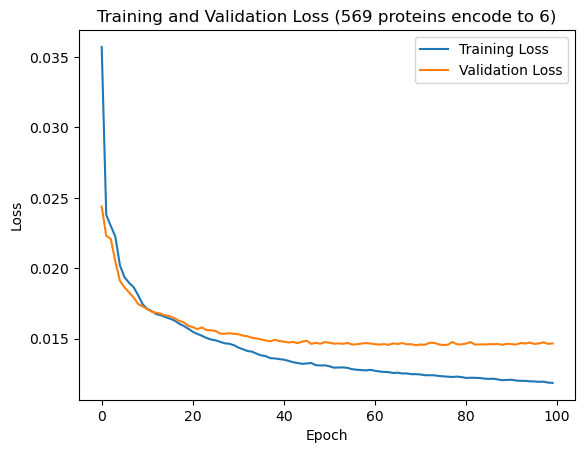

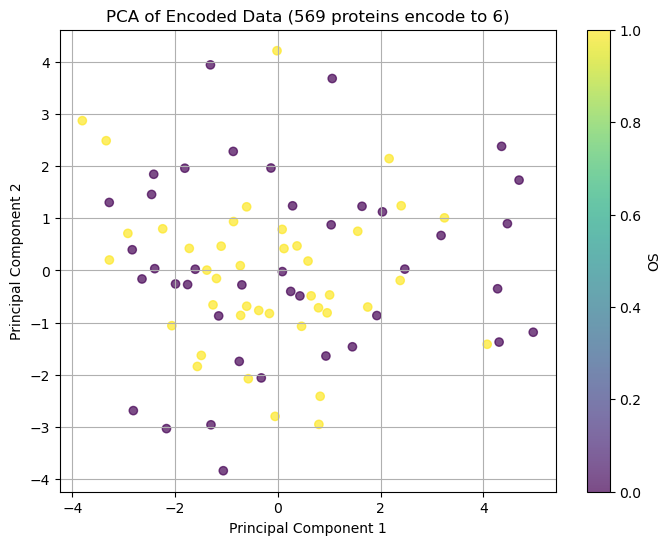

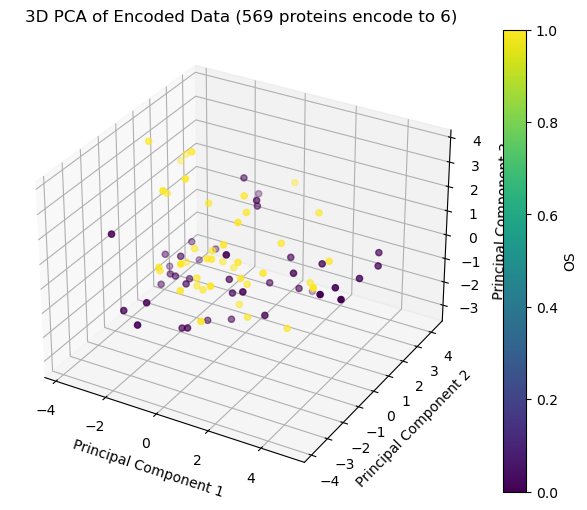

LogisticRegression - Mean CV Score: 0.5348639455782312
LogisticRegression - Mean Confusion Matrix:
[[10.8 12.4]
 [10.2 15.2]]
SVM - Mean CV Score: 0.5928571428571429
SVM - Mean Confusion Matrix:
[[14.2  9. ]
 [10.8 14.6]]
RandomForest - Mean CV Score: 0.5431972789115647
RandomForest - Mean Confusion Matrix:
[[11.6 11.6]
 [10.6 14.8]]
KNN - Mean CV Score: 0.5759353741496598
KNN - Mean Confusion Matrix:
[[15.   8.2]
 [12.4 13. ]]
GradientBoosting - Mean CV Score: 0.5598639455782313
GradientBoosting - Mean Confusion Matrix:
[[12.4 10.8]
 [10.6 14.8]]
AdaBoost - Mean CV Score: 0.5764455782312925
AdaBoost - Mean Confusion Matrix:
[[12.6 10.6]
 [10.  15.4]]
NaiveBayes - Mean CV Score: 0.5806972789115645
NaiveBayes - Mean Confusion Matrix:
[[15.8  7.4]
 [13.  12.4]]
DecisionTree - Mean CV Score: 0.5185374149659864
DecisionTree - Mean Confusion Matrix:
[[11.2 12. ]
 [11.4 14. ]]
ExtraTrees - Mean CV Score: 0.555952380952381
ExtraTrees - Mean Confusion Matrix:
[[12.4 10.8]
 [10.8 14.6]]
XGBoost

In [46]:
AE_inputation = AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 6,type = "(569 proteins encode to 6)")
AE_inputation.train()
AE_inputation.plot()
AE_inputation.do_PCA(2)
AE_inputation.do_PCA(3)
AE_inputation.cross_validation_model_selection()

In [47]:
class Wider_AE(AE):
    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))
        encoder = Dense(256, activation='relu')(input_layer)

        encoder = Dense(128, activation='relu')(input_layer)
        encoder = Dense(64, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(64, activation='relu')(bottleneck)
        decoder = Dense(128, activation='relu')(decoder)
        decoder = Dense(256, activation='relu')(decoder)

        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        self.history = self.autoencoder.fit(self.X_train, self.X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(self.X_test, self.X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()       


Epoch 1/100
22/31 [====================>.........] - ETA: 0s - loss: 0.0338
Epoch 1: val_loss improved from inf to 0.02395, saving model to model\(569 proteins encode to 12)_best_model.keras
31/31 [==============================] - 2s 18ms/step - loss: 0.0319 - val_loss: 0.0240
Epoch 2/100
31/31 [==============================] - ETA: 0s - loss: 0.0233
Epoch 2: val_loss improved from 0.02395 to 0.02130, saving model to model\(569 proteins encode to 12)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0233 - val_loss: 0.0213
Epoch 3/100
30/31 [============================>.] - ETA: 0s - loss: 0.0204
Epoch 3: val_loss improved from 0.02130 to 0.01876, saving model to model\(569 proteins encode to 12)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0204 - val_loss: 0.0188
Epoch 4/100
26/31 [========================>.....] - ETA: 0s - loss: 0.0192
Epoch 4: val_loss improved from 0.01876 to 0.01819, saving model to model\(569 pr

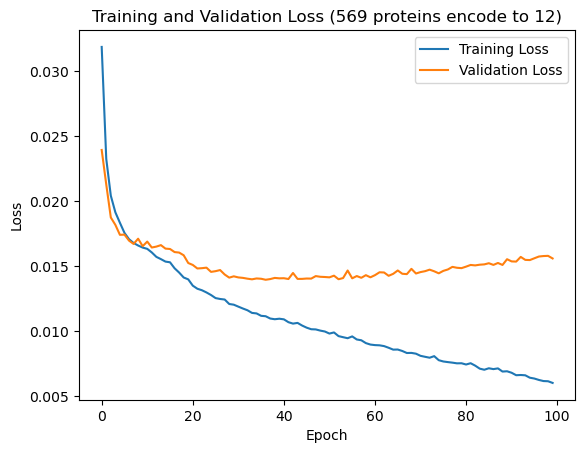

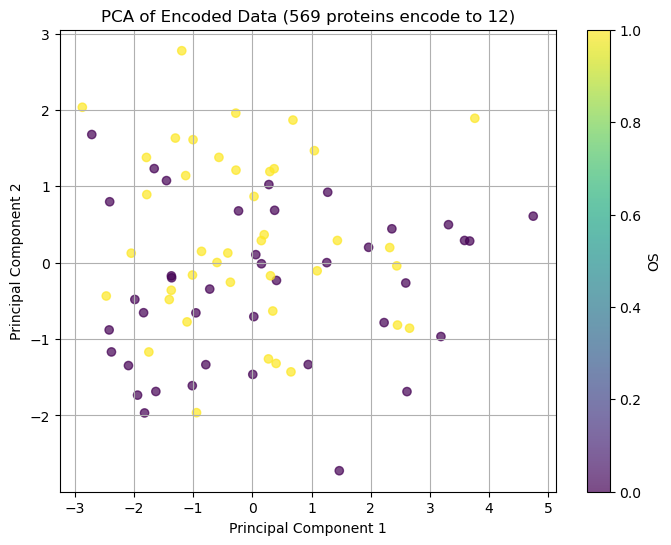

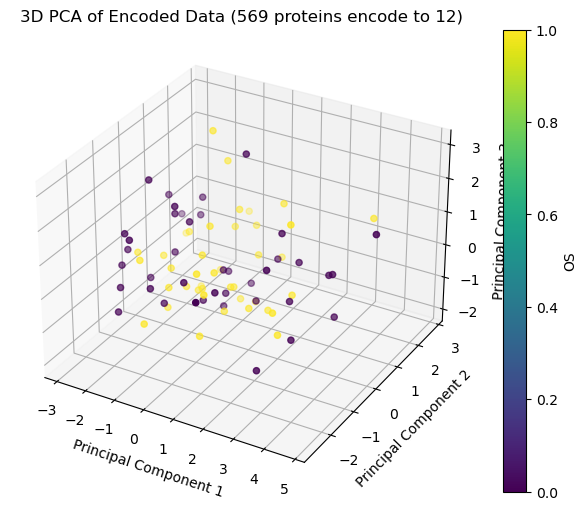

LogisticRegression - Mean CV Score: 0.5840136054421768
LogisticRegression - Mean Confusion Matrix:
[[12.4 10.8]
 [ 9.4 16. ]]
SVM - Mean CV Score: 0.6007653061224489
SVM - Mean Confusion Matrix:
[[12.2 11. ]
 [ 8.4 17. ]]
RandomForest - Mean CV Score: 0.6172619047619048
RandomForest - Mean Confusion Matrix:
[[14.   9.2]
 [ 9.4 16. ]]
KNN - Mean CV Score: 0.6131802721088435
KNN - Mean Confusion Matrix:
[[14.8  8.4]
 [10.4 15. ]]
GradientBoosting - Mean CV Score: 0.5678571428571428
GradientBoosting - Mean Confusion Matrix:
[[13.2 10. ]
 [11.  14.4]]
AdaBoost - Mean CV Score: 0.5844387755102041
AdaBoost - Mean Confusion Matrix:
[[13.8  9.4]
 [10.8 14.6]]
NaiveBayes - Mean CV Score: 0.547704081632653
NaiveBayes - Mean Confusion Matrix:
[[15.8  7.4]
 [14.6 10.8]]
DecisionTree - Mean CV Score: 0.5598639455782314
DecisionTree - Mean Confusion Matrix:
[[12.6 10.6]
 [10.8 14.6]]
ExtraTrees - Mean CV Score: 0.6295068027210884
ExtraTrees - Mean Confusion Matrix:
[[13.8  9.4]
 [ 8.6 16.8]]
XGBoost

In [48]:
WAE_inputation_12d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 12,type = "(569 proteins encode to 12)")
WAE_inputation_12d.train()
WAE_inputation_12d.plot()
WAE_inputation_12d.do_PCA(2)
WAE_inputation_12d.do_PCA(3)
WAE_inputation_12d.cross_validation_model_selection()



Epoch 1/100
30/31 [============================>.] - ETA: 0s - loss: 0.0295
Epoch 1: val_loss improved from inf to 0.02273, saving model to model\(569 proteins encode to 24)_best_model.keras
31/31 [==============================] - 2s 16ms/step - loss: 0.0294 - val_loss: 0.0227
Epoch 2/100
30/31 [============================>.] - ETA: 0s - loss: 0.0231
Epoch 2: val_loss improved from 0.02273 to 0.02224, saving model to model\(569 proteins encode to 24)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0232 - val_loss: 0.0222
Epoch 3/100
30/31 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 3: val_loss improved from 0.02224 to 0.01927, saving model to model\(569 proteins encode to 24)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0218 - val_loss: 0.0193
Epoch 4/100
30/31 [============================>.] - ETA: 0s - loss: 0.0193
Epoch 4: val_loss improved from 0.01927 to 0.01835, saving model to model\(569 pr

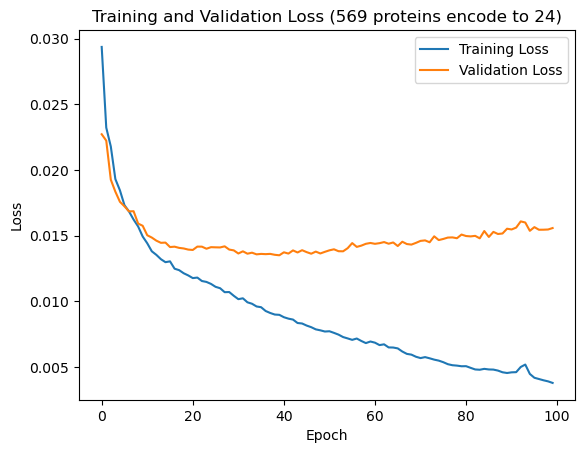

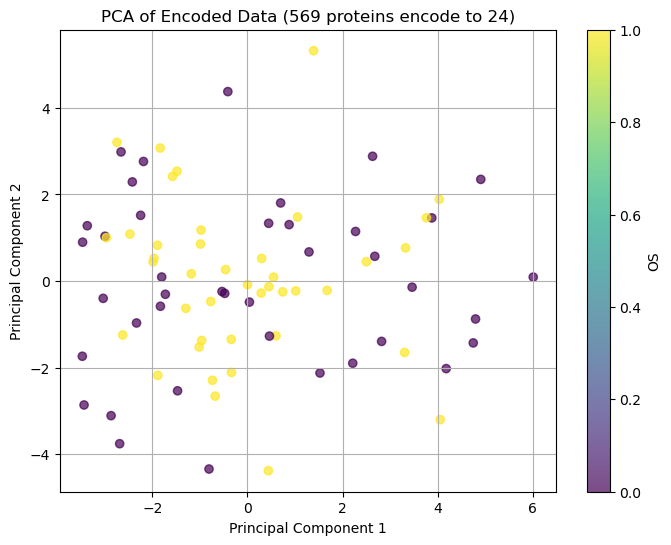

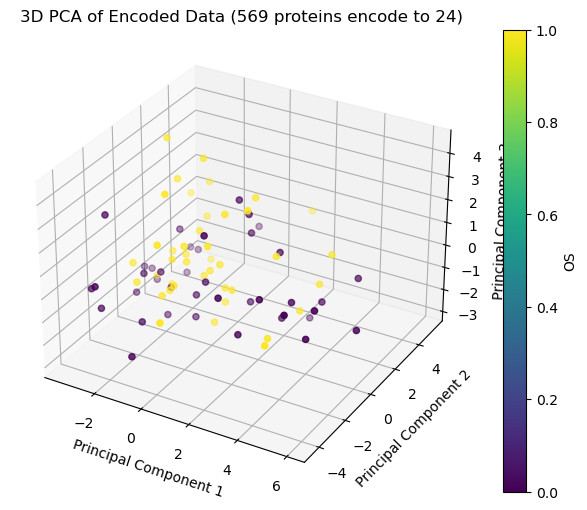

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression - Mean CV Score: 0.5799319727891157
LogisticRegression - Mean Confusion Matrix:
[[13.4  9.8]
 [10.6 14.8]]
SVM - Mean CV Score: 0.6051020408163266
SVM - Mean Confusion Matrix:
[[12.4 10.8]
 [ 8.4 17. ]]
RandomForest - Mean CV Score: 0.6048469387755102
RandomForest - Mean Confusion Matrix:
[[12.  11.2]
 [ 8.  17.4]]
KNN - Mean CV Score: 0.5510204081632654
KNN - Mean Confusion Matrix:
[[13.2 10. ]
 [11.8 13.6]]
GradientBoosting - Mean CV Score: 0.572108843537415
GradientBoosting - Mean Confusion Matrix:
[[12.2 11. ]
 [ 9.8 15.6]]
AdaBoost - Mean CV Score: 0.5800170068027211
AdaBoost - Mean Confusion Matrix:
[[14.   9.2]
 [11.2 14.2]]
NaiveBayes - Mean CV Score: 0.5886904761904762
NaiveBayes - Mean Confusion Matrix:
[[16.6  6.6]
 [13.4 12. ]]
DecisionTree - Mean CV Score: 0.5640306122448979
DecisionTree - Mean Confusion Matrix:
[[13.4  9.8]
 [11.4 14. ]]
ExtraTrees - Mean CV Score: 0.6048469387755102
ExtraTrees - Mean Confusion Matrix:
[[14.2  9. ]
 [10.2 15.2]]
XGBoost

In [49]:
WAE_inputation_24d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 24,type = "(569 proteins encode to 24)")
WAE_inputation_24d.train()
WAE_inputation_24d.plot()
WAE_inputation_24d.do_PCA(2)
WAE_inputation_24d.do_PCA(3)
WAE_inputation_24d.cross_validation_model_selection()


Epoch 1/100
31/31 [==============================] - ETA: 0s - loss: 0.0302
Epoch 1: val_loss improved from inf to 0.02267, saving model to model\(569 proteins encode to 28)_best_model.keras
31/31 [==============================] - 2s 16ms/step - loss: 0.0302 - val_loss: 0.0227
Epoch 2/100
30/31 [============================>.] - ETA: 0s - loss: 0.0233
Epoch 2: val_loss improved from 0.02267 to 0.02214, saving model to model\(569 proteins encode to 28)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0234 - val_loss: 0.0221
Epoch 3/100
30/31 [============================>.] - ETA: 0s - loss: 0.0220
Epoch 3: val_loss improved from 0.02214 to 0.01950, saving model to model\(569 proteins encode to 28)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0219 - val_loss: 0.0195
Epoch 4/100
30/31 [============================>.] - ETA: 0s - loss: 0.0195
Epoch 4: val_loss improved from 0.01950 to 0.01842, saving model to model\(569 pr

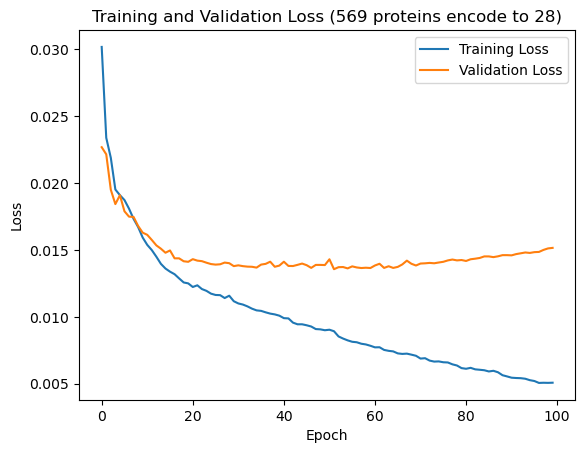

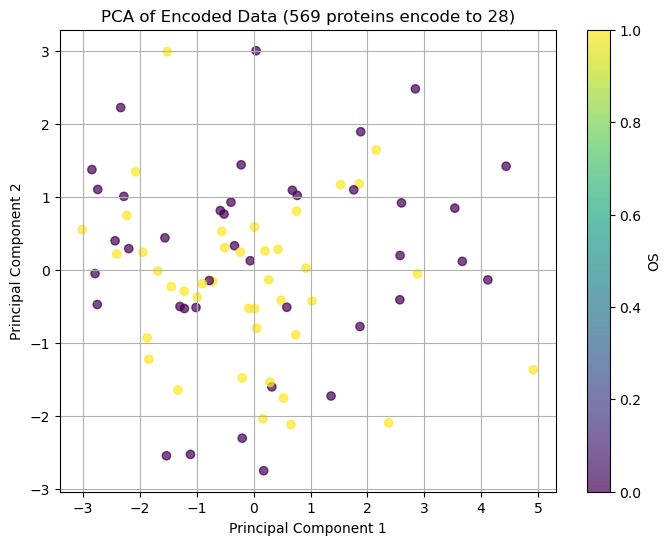

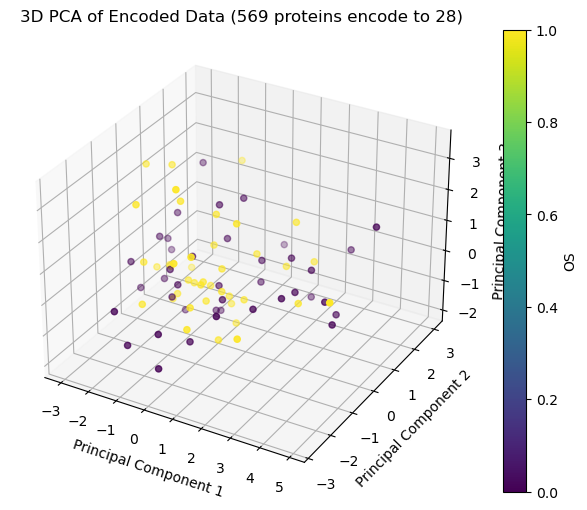

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression - Mean CV Score: 0.6044217687074831
LogisticRegression - Mean Confusion Matrix:
[[13.8  9.4]
 [ 9.8 15.6]]
SVM - Mean CV Score: 0.6168367346938776
SVM - Mean Confusion Matrix:
[[13.4  9.8]
 [ 8.8 16.6]]
RandomForest - Mean CV Score: 0.6008503401360545
RandomForest - Mean Confusion Matrix:
[[13.4  9.8]
 [ 9.6 15.8]]
KNN - Mean CV Score: 0.6085034013605443
KNN - Mean Confusion Matrix:
[[14.8  8.4]
 [10.6 14.8]]
GradientBoosting - Mean CV Score: 0.5552721088435375
GradientBoosting - Mean Confusion Matrix:
[[12.8 10.4]
 [11.2 14.2]]
AdaBoost - Mean CV Score: 0.6089285714285715
AdaBoost - Mean Confusion Matrix:
[[14.8  8.4]
 [10.6 14.8]]
NaiveBayes - Mean CV Score: 0.54328231292517
NaiveBayes - Mean Confusion Matrix:
[[22.2  1. ]
 [21.2  4.2]]
DecisionTree - Mean CV Score: 0.5434523809523809
DecisionTree - Mean Confusion Matrix:
[[13.  10.2]
 [12.  13.4]]
ExtraTrees - Mean CV Score: 0.5965136054421768
ExtraTrees - Mean Confusion Matrix:
[[13.4  9.8]
 [ 9.8 15.6]]
XGBoost 

In [50]:
WAE_inputation_28d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 28,type = "(569 proteins encode to 28)")
WAE_inputation_28d.train()
WAE_inputation_28d.plot()
WAE_inputation_28d.do_PCA(2)
WAE_inputation_28d.do_PCA(3)
WAE_inputation_28d.cross_validation_model_selection()


Epoch 1/100
17/31 [===============>..............] - ETA: 0s - loss: 0.0356 
Epoch 1: val_loss improved from inf to 0.02269, saving model to model\(569 proteins encode to 18)_best_model.keras
31/31 [==============================] - 2s 16ms/step - loss: 0.0304 - val_loss: 0.0227
Epoch 2/100
30/31 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 2: val_loss improved from 0.02269 to 0.02083, saving model to model\(569 proteins encode to 18)_best_model.keras
31/31 [==============================] - 0s 9ms/step - loss: 0.0229 - val_loss: 0.0208
Epoch 3/100
16/31 [==============>...............] - ETA: 0s - loss: 0.0203
Epoch 3: val_loss improved from 0.02083 to 0.01941, saving model to model\(569 proteins encode to 18)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0202 - val_loss: 0.0194
Epoch 4/100
28/31 [==========================>...] - ETA: 0s - loss: 0.0194
Epoch 4: val_loss improved from 0.01941 to 0.01853, saving model to model\(569 p

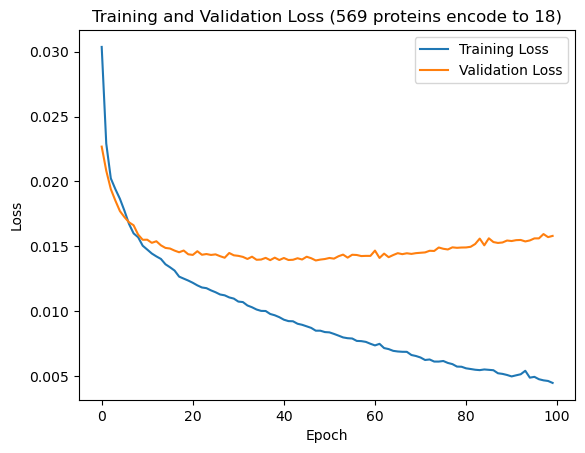

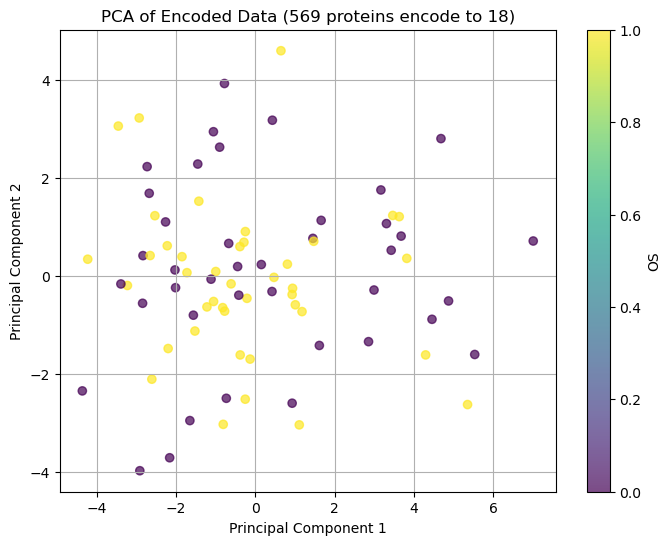

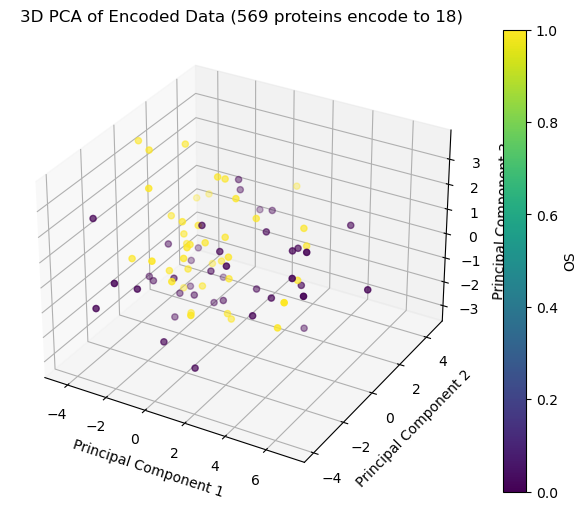

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression - Mean CV Score: 0.5679421768707483
LogisticRegression - Mean Confusion Matrix:
[[12.6 10.6]
 [10.4 15. ]]
SVM - Mean CV Score: 0.5844387755102041
SVM - Mean Confusion Matrix:
[[12.  11.2]
 [ 9.  16.4]]
RandomForest - Mean CV Score: 0.6170918367346939
RandomForest - Mean Confusion Matrix:
[[12.4 10.8]
 [ 7.8 17.6]]
KNN - Mean CV Score: 0.5965986394557824
KNN - Mean Confusion Matrix:
[[15.   8.2]
 [11.4 14. ]]
GradientBoosting - Mean CV Score: 0.5798469387755102
GradientBoosting - Mean Confusion Matrix:
[[13.2 10. ]
 [10.4 15. ]]
AdaBoost - Mean CV Score: 0.5595238095238095
AdaBoost - Mean Confusion Matrix:
[[12.8 10.4]
 [11.  14.4]]
NaiveBayes - Mean CV Score: 0.6133503401360543
NaiveBayes - Mean Confusion Matrix:
[[15.4  7.8]
 [11.  14.4]]
DecisionTree - Mean CV Score: 0.539030612244898
DecisionTree - Mean Confusion Matrix:
[[13.2 10. ]
 [12.4 13. ]]
ExtraTrees - Mean CV Score: 0.6126700680272108
ExtraTrees - Mean Confusion Matrix:
[[13.  10.2]
 [ 8.6 16.8]]
XGBoost

In [52]:
WAE_inputation_18d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 18,type = "(569 proteins encode to 18)")
WAE_inputation_18d.train()
WAE_inputation_18d.plot()
WAE_inputation_18d.do_PCA(2)
WAE_inputation_18d.do_PCA(3)
WAE_inputation_18d.cross_validation_model_selection()


Epoch 1/100
31/31 [==============================] - ETA: 0s - loss: 0.0314
Epoch 1: val_loss improved from inf to 0.02355, saving model to model\(569 proteins encode to 28)_best_model.keras
31/31 [==============================] - 2s 17ms/step - loss: 0.0314 - val_loss: 0.0235
Epoch 2/100
28/31 [==========================>...] - ETA: 0s - loss: 0.0235
Epoch 2: val_loss improved from 0.02355 to 0.02233, saving model to model\(569 proteins encode to 28)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0235 - val_loss: 0.0223
Epoch 3/100
28/31 [==========================>...] - ETA: 0s - loss: 0.0227
Epoch 3: val_loss improved from 0.02233 to 0.02123, saving model to model\(569 proteins encode to 28)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0228 - val_loss: 0.0212
Epoch 4/100
29/31 [===========================>..] - ETA: 0s - loss: 0.0206
Epoch 4: val_loss improved from 0.02123 to 0.01877, saving model to model\(569 pr

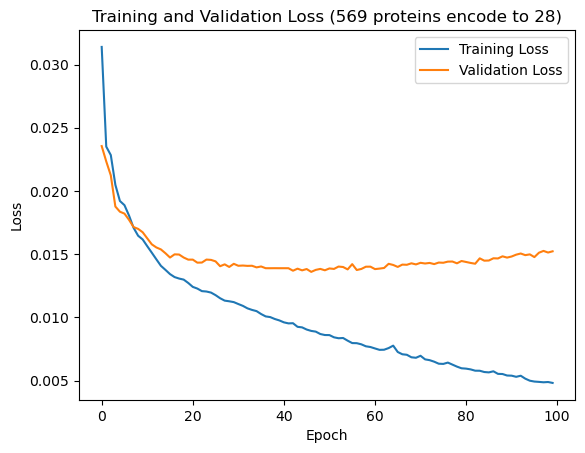

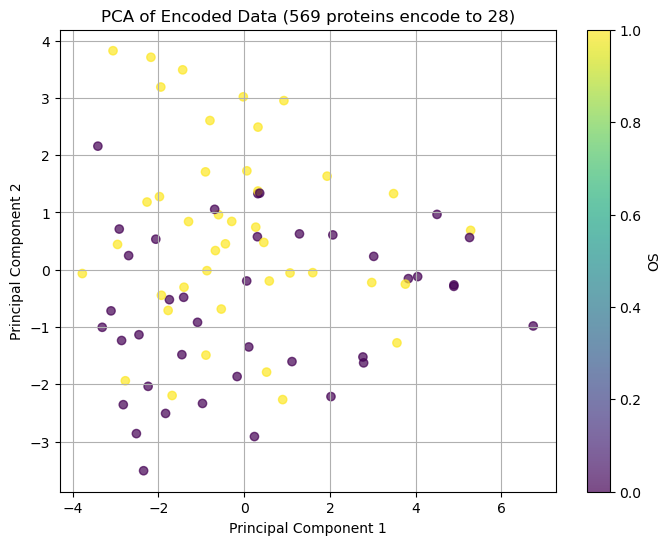

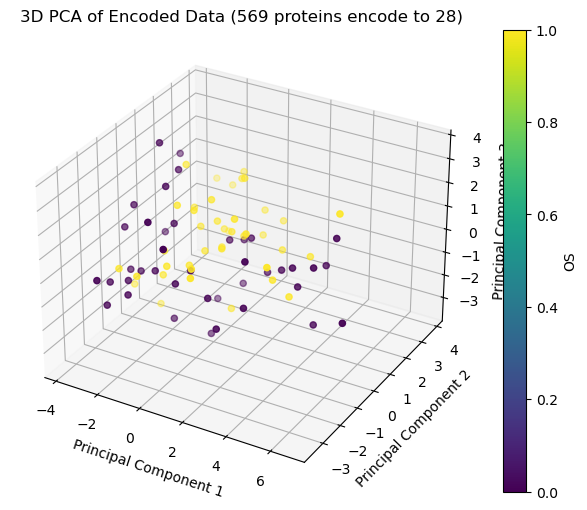

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression - Mean CV Score: 0.5636054421768707
LogisticRegression - Mean Confusion Matrix:
[[12.6 10.6]
 [10.6 14.8]]
SVM - Mean CV Score: 0.6006802721088434
SVM - Mean Confusion Matrix:
[[12.  11.2]
 [ 8.2 17.2]]
RandomForest - Mean CV Score: 0.6378401360544217
RandomForest - Mean Confusion Matrix:
[[14.6  8.6]
 [ 9.  16.4]]
KNN - Mean CV Score: 0.5884353741496599
KNN - Mean Confusion Matrix:
[[15.2  8. ]
 [12.  13.4]]
GradientBoosting - Mean CV Score: 0.6006802721088434
GradientBoosting - Mean Confusion Matrix:
[[12.6 10.6]
 [ 8.8 16.6]]
AdaBoost - Mean CV Score: 0.5761904761904761
AdaBoost - Mean Confusion Matrix:
[[12.6 10.6]
 [10.  15.4]]
NaiveBayes - Mean CV Score: 0.5683673469387756
NaiveBayes - Mean Confusion Matrix:
[[14.2  9. ]
 [12.  13.4]]
DecisionTree - Mean CV Score: 0.5556122448979592
DecisionTree - Mean Confusion Matrix:
[[13.2 10. ]
 [11.6 13.8]]
ExtraTrees - Mean CV Score: 0.6383503401360544
ExtraTrees - Mean Confusion Matrix:
[[14.6  8.6]
 [ 9.  16.4]]
XGBoos

In [53]:
WAE_inputation_28d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 28,type = "(569 proteins encode to 28)")
WAE_inputation_28d.train()
WAE_inputation_28d.plot()
WAE_inputation_28d.do_PCA(2)
WAE_inputation_28d.do_PCA(3)
WAE_inputation_28d.cross_validation_model_selection()


Epoch 1/100
25/31 [=======================>......] - ETA: 0s - loss: 0.0307 
Epoch 1: val_loss improved from inf to 0.02244, saving model to model\(569 proteins encode to 48)_best_model.keras
31/31 [==============================] - 3s 20ms/step - loss: 0.0294 - val_loss: 0.0224
Epoch 2/100
21/31 [===================>..........] - ETA: 0s - loss: 0.0235
Epoch 2: val_loss improved from 0.02244 to 0.02015, saving model to model\(569 proteins encode to 48)_best_model.keras
31/31 [==============================] - 0s 10ms/step - loss: 0.0227 - val_loss: 0.0201
Epoch 3/100
23/31 [=====================>........] - ETA: 0s - loss: 0.0200
Epoch 3: val_loss improved from 0.02015 to 0.01891, saving model to model\(569 proteins encode to 48)_best_model.keras
31/31 [==============================] - 0s 10ms/step - loss: 0.0200 - val_loss: 0.0189
Epoch 4/100
24/31 [======================>.......] - ETA: 0s - loss: 0.0185
Epoch 4: val_loss improved from 0.01891 to 0.01811, saving model to model\(569

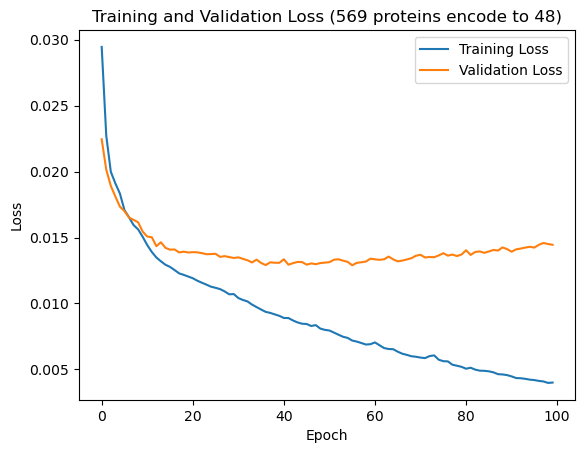

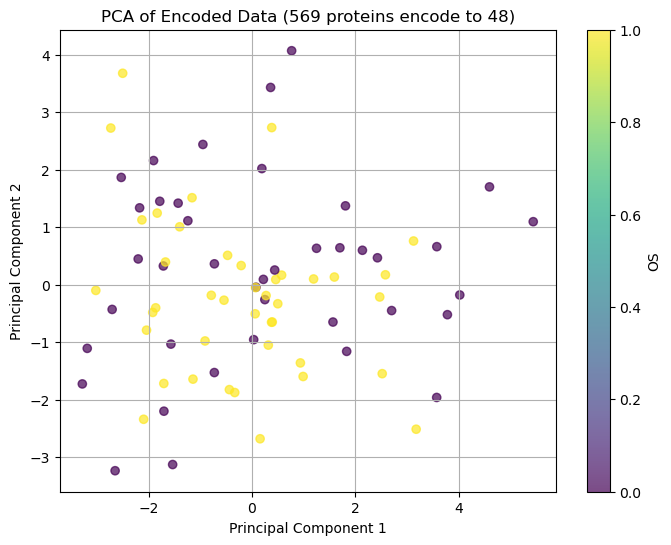

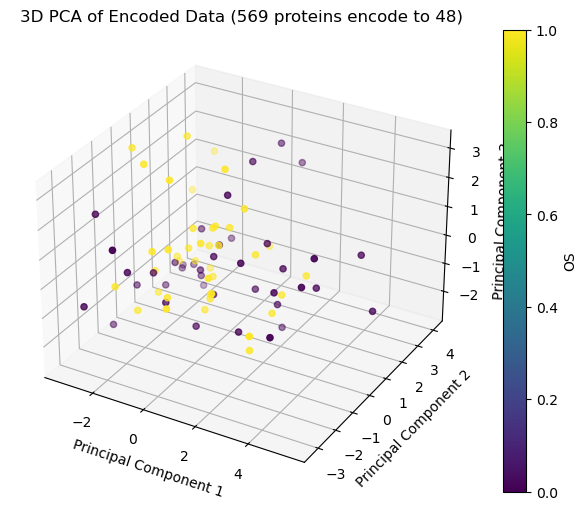

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression - Mean CV Score: 0.6009353741496599
LogisticRegression - Mean Confusion Matrix:
[[12.8 10.4]
 [ 9.  16.4]]
SVM - Mean CV Score: 0.6210884353741496
SVM - Mean Confusion Matrix:
[[12.4 10.8]
 [ 7.6 17.8]]
RandomForest - Mean CV Score: 0.6004251700680272
RandomForest - Mean Confusion Matrix:
[[12.  11.2]
 [ 8.2 17.2]]
KNN - Mean CV Score: 0.6043367346938775
KNN - Mean Confusion Matrix:
[[13.4  9.8]
 [ 9.4 16. ]]
GradientBoosting - Mean CV Score: 0.6460034013605442
GradientBoosting - Mean Confusion Matrix:
[[13.  10.2]
 [ 7.  18.4]]
AdaBoost - Mean CV Score: 0.5843537414965986
AdaBoost - Mean Confusion Matrix:
[[13.2 10. ]
 [10.2 15.2]]
NaiveBayes - Mean CV Score: 0.5514455782312925
NaiveBayes - Mean Confusion Matrix:
[[ 6.8 16.4]
 [ 5.4 20. ]]
DecisionTree - Mean CV Score: 0.5552721088435375
DecisionTree - Mean Confusion Matrix:
[[12.4 10.8]
 [10.8 14.6]]
ExtraTrees - Mean CV Score: 0.6127551020408164
ExtraTrees - Mean Confusion Matrix:
[[13.2 10. ]
 [ 8.8 16.6]]
XGBoos

In [54]:
WAE_inputation_48d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 48,type = "(569 proteins encode to 48)")
WAE_inputation_48d.train()
WAE_inputation_48d.plot()
WAE_inputation_48d.do_PCA(2)
WAE_inputation_48d.do_PCA(3)
WAE_inputation_48d.cross_validation_model_selection()


Epoch 1/100
29/31 [===========================>..] - ETA: 0s - loss: 0.0312
Epoch 1: val_loss improved from inf to 0.02315, saving model to model\(569 proteins encode to 36)_best_model.keras
31/31 [==============================] - 2s 17ms/step - loss: 0.0307 - val_loss: 0.0231
Epoch 2/100
28/31 [==========================>...] - ETA: 0s - loss: 0.0228
Epoch 2: val_loss improved from 0.02315 to 0.02061, saving model to model\(569 proteins encode to 36)_best_model.keras
31/31 [==============================] - 0s 9ms/step - loss: 0.0229 - val_loss: 0.0206
Epoch 3/100
28/31 [==========================>...] - ETA: 0s - loss: 0.0198
Epoch 3: val_loss improved from 0.02061 to 0.01878, saving model to model\(569 proteins encode to 36)_best_model.keras
31/31 [==============================] - 0s 9ms/step - loss: 0.0201 - val_loss: 0.0188
Epoch 4/100
27/31 [=========================>....] - ETA: 0s - loss: 0.0192
Epoch 4: val_loss improved from 0.01878 to 0.01852, saving model to model\(569 pr

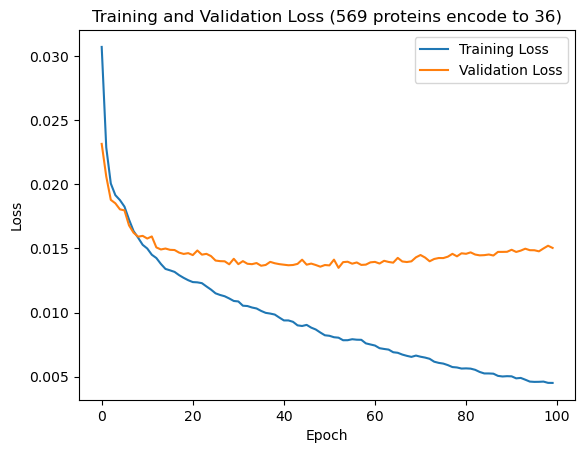

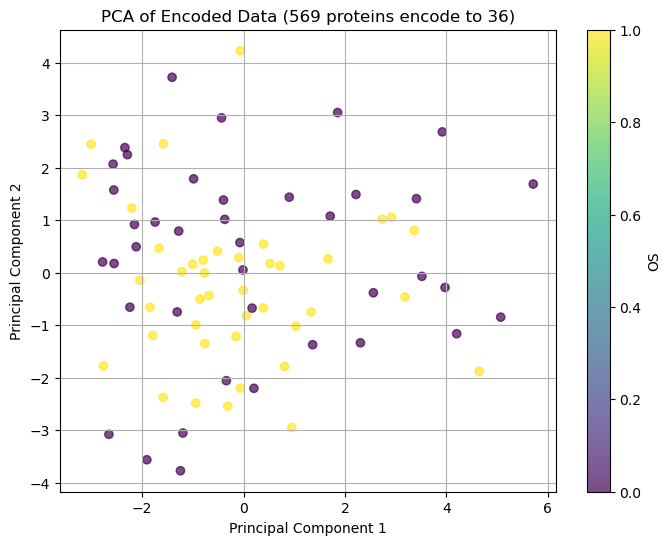

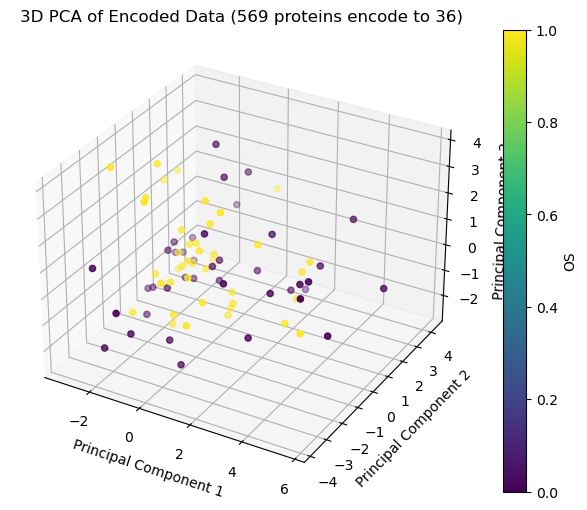

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression - Mean CV Score: 0.6337585034013605
LogisticRegression - Mean Confusion Matrix:
[[13.6  9.6]
 [ 8.2 17.2]]
SVM - Mean CV Score: 0.616921768707483
SVM - Mean Confusion Matrix:
[[13.  10.2]
 [ 8.4 17. ]]
RandomForest - Mean CV Score: 0.646343537414966
RandomForest - Mean Confusion Matrix:
[[13.8  9.4]
 [ 7.8 17.6]]
KNN - Mean CV Score: 0.6331632653061224
KNN - Mean Confusion Matrix:
[[15.6  7.6]
 [10.2 15.2]]
GradientBoosting - Mean CV Score: 0.6500850340136054
GradientBoosting - Mean Confusion Matrix:
[[14.2  9. ]
 [ 8.  17.4]]
AdaBoost - Mean CV Score: 0.5803571428571429
AdaBoost - Mean Confusion Matrix:
[[13.4  9.8]
 [10.6 14.8]]
NaiveBayes - Mean CV Score: 0.576360544217687
NaiveBayes - Mean Confusion Matrix:
[[17.   6.2]
 [14.4 11. ]]
DecisionTree - Mean CV Score: 0.5883503401360544
DecisionTree - Mean Confusion Matrix:
[[12.2 11. ]
 [ 9.  16.4]]
ExtraTrees - Mean CV Score: 0.633843537414966
ExtraTrees - Mean Confusion Matrix:
[[13.8  9.4]
 [ 8.4 17. ]]
XGBoost - 

In [55]:
WAE_inputation_36d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 36,type = "(569 proteins encode to 36)")
WAE_inputation_36d.train()
WAE_inputation_36d.plot()
WAE_inputation_36d.do_PCA(2)
WAE_inputation_36d.do_PCA(3)
WAE_inputation_36d.cross_validation_model_selection()


Epoch 1/100
29/31 [===========================>..] - ETA: 0s - loss: 0.0295
Epoch 1: val_loss improved from inf to 0.02277, saving model to model\(569 proteins encode to 28)_best_model.keras
31/31 [==============================] - 3s 18ms/step - loss: 0.0295 - val_loss: 0.0228
Epoch 2/100
29/31 [===========================>..] - ETA: 0s - loss: 0.0229
Epoch 2: val_loss improved from 0.02277 to 0.02071, saving model to model\(569 proteins encode to 28)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0227 - val_loss: 0.0207
Epoch 3/100
27/31 [=========================>....] - ETA: 0s - loss: 0.0204
Epoch 3: val_loss improved from 0.02071 to 0.01876, saving model to model\(569 proteins encode to 28)_best_model.keras
31/31 [==============================] - 0s 9ms/step - loss: 0.0202 - val_loss: 0.0188
Epoch 4/100
29/31 [===========================>..] - ETA: 0s - loss: 0.0191
Epoch 4: val_loss improved from 0.01876 to 0.01805, saving model to model\(569 pr

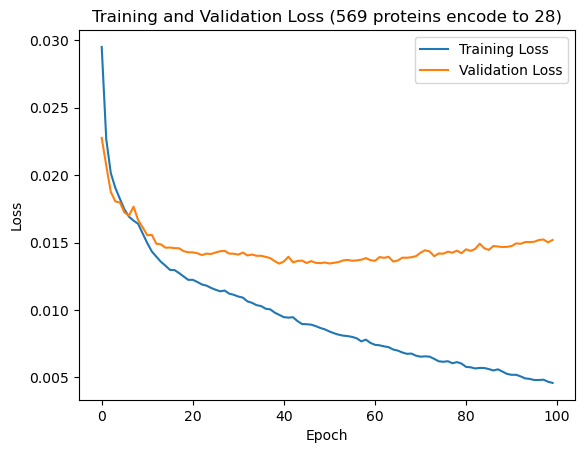

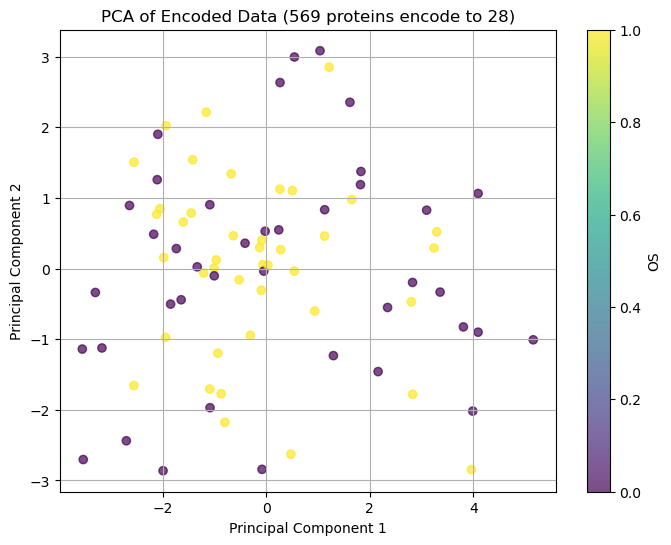

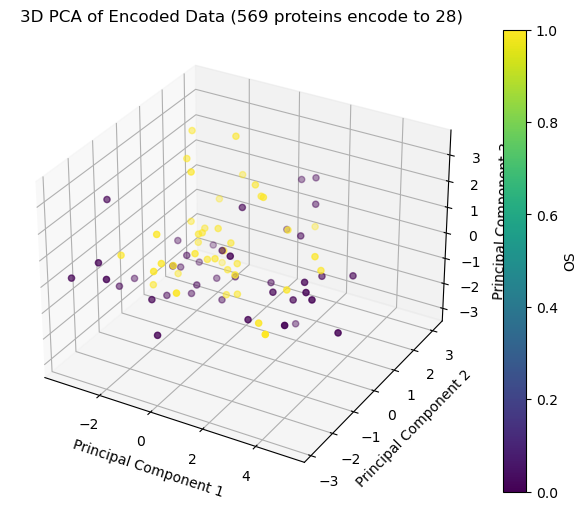

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression - Mean CV Score: 0.5796768707482993
LogisticRegression - Mean Confusion Matrix:
[[11.4 11.8]
 [ 8.6 16.8]]
SVM - Mean CV Score: 0.5886904761904762
SVM - Mean Confusion Matrix:
[[11.6 11.6]
 [ 8.4 17. ]]
RandomForest - Mean CV Score: 0.6177721088435374
RandomForest - Mean Confusion Matrix:
[[12.6 10.6]
 [ 8.  17.4]]
KNN - Mean CV Score: 0.5676020408163265
KNN - Mean Confusion Matrix:
[[14.   9.2]
 [11.8 13.6]]
GradientBoosting - Mean CV Score: 0.5760204081632654
GradientBoosting - Mean Confusion Matrix:
[[12.2 11. ]
 [ 9.6 15.8]]
AdaBoost - Mean CV Score: 0.6008503401360544
AdaBoost - Mean Confusion Matrix:
[[13.2 10. ]
 [ 9.4 16. ]]
NaiveBayes - Mean CV Score: 0.5520408163265306
NaiveBayes - Mean Confusion Matrix:
[[13.4  9.8]
 [12.  13.4]]
DecisionTree - Mean CV Score: 0.5803571428571429
DecisionTree - Mean Confusion Matrix:
[[13.4  9.8]
 [10.6 14.8]]
ExtraTrees - Mean CV Score: 0.5927721088435374
ExtraTrees - Mean Confusion Matrix:
[[12.6 10.6]
 [ 9.2 16.2]]
XGBoos

In [56]:
WAE_inputation_28d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 28,type = "(569 proteins encode to 28)")
WAE_inputation_28d.train()
WAE_inputation_28d.plot()
WAE_inputation_28d.do_PCA(2)
WAE_inputation_28d.do_PCA(3)
WAE_inputation_28d.cross_validation_model_selection()


Epoch 1/100
30/31 [============================>.] - ETA: 0s - loss: 0.0302
Epoch 1: val_loss improved from inf to 0.02337, saving model to model\(569 proteins encode to 34)_best_model.keras
31/31 [==============================] - 2s 16ms/step - loss: 0.0301 - val_loss: 0.0234
Epoch 2/100
30/31 [============================>.] - ETA: 0s - loss: 0.0235
Epoch 2: val_loss improved from 0.02337 to 0.02225, saving model to model\(569 proteins encode to 34)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0234 - val_loss: 0.0223
Epoch 3/100
29/31 [===========================>..] - ETA: 0s - loss: 0.0227
Epoch 3: val_loss improved from 0.02225 to 0.02047, saving model to model\(569 proteins encode to 34)_best_model.keras
31/31 [==============================] - 0s 9ms/step - loss: 0.0226 - val_loss: 0.0205
Epoch 4/100
28/31 [==========================>...] - ETA: 0s - loss: 0.0200
Epoch 4: val_loss improved from 0.02047 to 0.01929, saving model to model\(569 pr

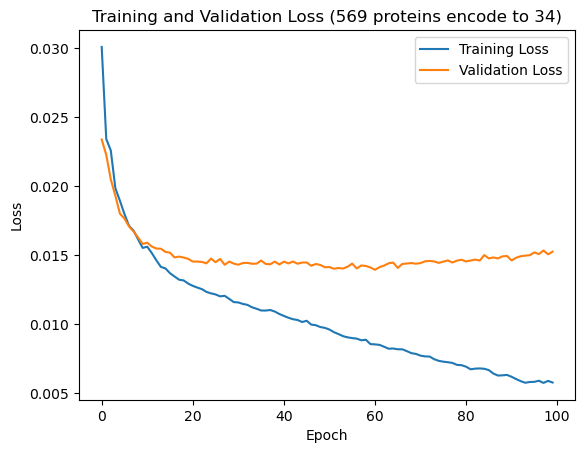

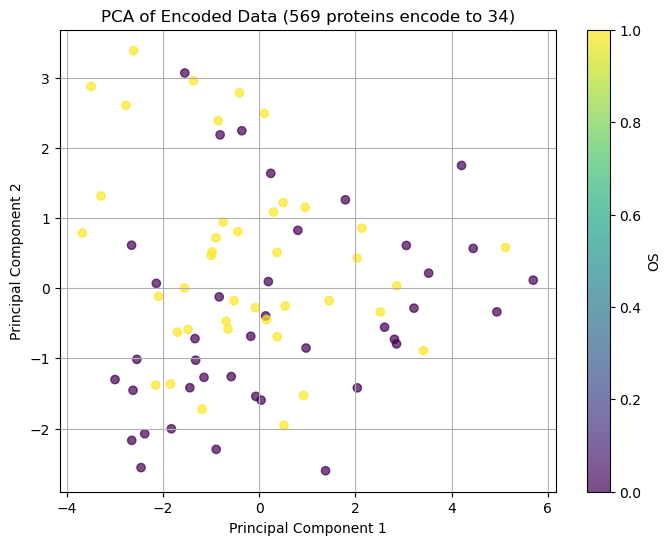

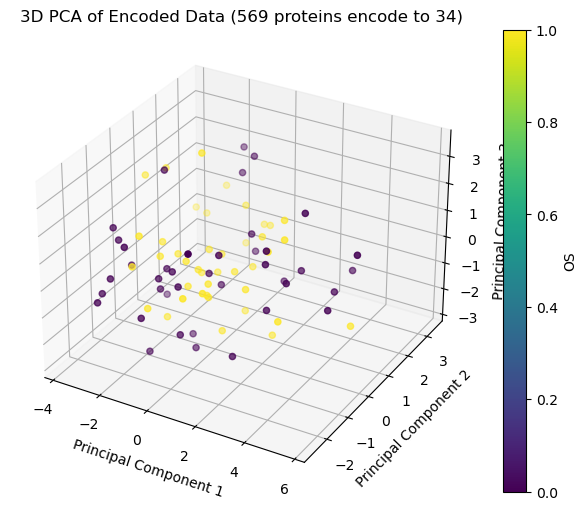

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression - Mean CV Score: 0.5841836734693878
LogisticRegression - Mean Confusion Matrix:
[[12.4 10.8]
 [ 9.4 16. ]]
SVM - Mean CV Score: 0.5966836734693878
SVM - Mean Confusion Matrix:
[[12.4 10.8]
 [ 8.8 16.6]]
RandomForest - Mean CV Score: 0.5967687074829933
RandomForest - Mean Confusion Matrix:
[[10.8 12.4]
 [ 7.2 18.2]]
KNN - Mean CV Score: 0.5845238095238096
KNN - Mean Confusion Matrix:
[[14.6  8.6]
 [11.6 13.8]]
GradientBoosting - Mean CV Score: 0.5928571428571427
GradientBoosting - Mean Confusion Matrix:
[[13.8  9.4]
 [10.4 15. ]]
AdaBoost - Mean CV Score: 0.5557823129251701
AdaBoost - Mean Confusion Matrix:
[[13.  10.2]
 [11.4 14. ]]
NaiveBayes - Mean CV Score: 0.5889455782312926
NaiveBayes - Mean Confusion Matrix:
[[15.6  7.6]
 [12.4 13. ]]
DecisionTree - Mean CV Score: 0.547108843537415
DecisionTree - Mean Confusion Matrix:
[[12.  11.2]
 [10.8 14.6]]
ExtraTrees - Mean CV Score: 0.6130102040816326
ExtraTrees - Mean Confusion Matrix:
[[12.8 10.4]
 [ 8.4 17. ]]
XGBoost

In [57]:
WAE_inputation_34d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 34,type = "(569 proteins encode to 34)")
WAE_inputation_34d.train()
WAE_inputation_34d.plot()
WAE_inputation_34d.do_PCA(2)
WAE_inputation_34d.do_PCA(3)
WAE_inputation_34d.cross_validation_model_selection()


# Resources Investigation:

ICGC:
https://dcc.icgc.org/repositories?filters=%7B%22file%22:%7B%20%22projectCode%22:%7B%22is%22:%5B%22HNSC-US%22%5D%7D%7D%7D

 Data Type
 SSM  2,126
 Aligned Reads  2,037
 Clinical Data  453
 Biospecimen Data  448
 StSM  223
 SGV  132
 CNSM  88
 StGV  88

TCPA:
https://www.tcpaportal.org/tcpa/download.html

TCGA of 2018, with L4(normalized across RPPA batches therefore enable pan-cancer)

PDC:
https://proteomic.datacommons.cancer.gov/pdc/browse
3 studies, but Mass Spectrum not RPPA, therefore only contains Peptide result. do have clinincal though

HNSCC PDX: 
https://aacrjournals.org/mcr/article/14/3/278/89624/Proteomic-Characterization-of-Head-and-Neck-Cancer
RPPA, but on mention how to acess and probabaly wound not have clinical since the read from transplated rats.

HAP: Reference RNA and protein from healthy samples:
https://www.proteinatlas.org/about/download

Pride:Full MS sets
https://www.ebi.ac.uk/pride/archive?keyword=HNSCC,RPPA&sortDirection=DESC&page=0&pageSize=20

Paper HNSCC: RPPA but only target 60 specific protein
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3070553/

GEO: Some Protein profiling by protein array (RPPA), no HNSCC
https://www.ncbi.nlm.nih.gov/geo/browse/

ArraryExpress: RPPA for GBM, lung cancer, breast cancer
https://www.ebi.ac.uk/biostudies/arrayexpress/studies?query=RPPA

FANTOM6 Experiment Index: RNA-Seq
https://fantom.gsc.riken.jp/6/experiment_index/#/

Resources index: 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6971871/